<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W3D2_HiddenDynamics/student/W3D2_Tutorial5.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/student/W3D2_Tutorial5.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Bonus Tutorial 5: Expectation Maximization for spiking neurons
**Week 3, Day 2: Hidden Dynamics**

**By Neuromatch Academy**

__Content Creators:__ Yicheng Fei with help from Jesse Livezey

__Content Reviewers:__ John Butler, Matt Krause, Meenakshi Khosla, Spiros Chavlis, Michael Waskom

__Post-Production Team:__ Gagana B, Spiros Chavlis

<br>

**Important Note:** this material was developed in NMA 2020 and has not been revised according to the standards of the Hidden Dynamics material.

<br>

**Acknowledgements:** This tutorial is based on code originally created by Sean Escola.

---
# Tutorial objectives

We have learnt how the forward inference works in an HMM in Tutorial 2. In this optional tutorial, you will get a sense of how to perform parameter estimation of an HMM using the EM algorithm. **We encourage you to do these bonus exercises only _after_ you complete the core material in Tutorials 2, and 3.**

The EM algorithm is a powerful and widely used optimization tool that is much more general than HMMs. Since it is typically taught in the context of Hidden Markov Models, we include it here.

You will implement an HMM of a network of Poisson spiking neurons mentioned in today's intro and:

* Implement the forward-backward algorithm
* Complete the E-step and M-step 
* Learn parameters for the example problem using the EM algorithm
* Get an intuition of how the EM algorithm monotonically increases data likelihood

##  Video 1: Introduction


Video available at https://youtu.be/ceQXN0OUaFo


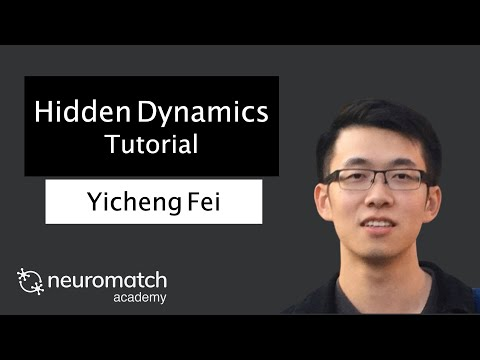

In [1]:
#@title Video 1: Introduction
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ceQXN0OUaFo", width=730, height=410, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In [2]:
import numpy as np
from scipy import stats
from scipy.optimize import linear_sum_assignment
from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib import patches

GaussianHMM1D = namedtuple('GaussianHMM1D', ['startprob', 'transmat','means','vars','n_components'])

##  Figure Settings


In [3]:
#@title Figure Settings
# import ipywidgets as widgets       # interactive display
from IPython.html import widgets
from ipywidgets import interactive, interact, HBox, Layout,VBox
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

ModuleNotFoundError: No module named 'IPython.html'

---

# Section 1: HMM for Poisson spiking neuronal network

##  Video 2: HMM for Poisson spiking neurons case study


Video available at https://youtu.be/Wb8mf5chmyI


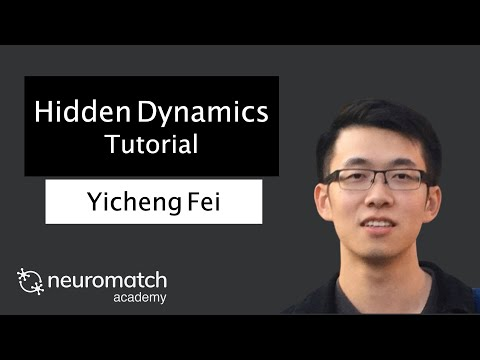

In [4]:
#@title Video 2: HMM for Poisson spiking neurons case study
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Wb8mf5chmyI", width=730, height=410, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Given noisy neural or behavioral measurements, we as neuroscientists often want to infer the unobserved latent variables as they change over time. Thalamic relay neurons fire in two distinct modes: a tonic mode where spikes are produced one at a time, and a 'burst mode' where several action potentials are produced in rapid succession. These modes are thought to differentially encode how the neurons relay information from sensory receptors to cortex. A distinct molecular mechanism, T-type calcium channels, switches neurons between modes, but it is very challenging to measure in the brain of a living monkey. However, statistical approaches let us recover the hidden state of those calcium channels purely from their spiking activity, which can be measured in a behaving monkey.

Here, we're going to tackle a simplified version of that problem.


Let's consider the formulation mentioned in the intro lecture. 
We have a network of $C$ neurons switching between $K$ states. Neuron $c$ has firing rate $\lambda_i^c$ in state $i$. The transition between states are represented by the $K\times K$ transition matrix $A_{ij}$ and initial probability vector $\psi$ with length $K$ at time $t=1$.

Let $y_t^c$ be the number of spikes for cell $c$ in time bin $t$.

<br>

In the following exercises (1 and 2) and tutorials, you will

* Define an instance of such model with $C=5$ and $K=3$
* Generate a dataset from this model
* (**Exercise 1**) Implement the M-step for this HMM
* Run EM to estimate all parameters $A,\psi,\lambda_i^c$
* Plot the learning likelihood curve
* Plot expected complete log likelihood versus data log likelihood
* Compare learnt parameters versus true parameters 

---


## Define model and generate data

Let's first generate a random state sequence from the hidden Markov Chain, and generate `n_frozen_trials` different trials of spike trains for each cell assuming they all use the same underlying sequence we just generated.

**Suggestions**

1. Run the following two sections **Model and simulation parameters** and **Initialize true model** to define a true model and parameters that will be used in our following exercises. Please take a look at the parameters and come back to these two cells if you encounter a variable you don't know in the future.

2. Run the provided code to convert a given state sequence to corresponding spike rates for all cells at all times, and use provided code to visualize all spike trains.



##  Helper functions


In [5]:
#@title Helper functions
def plot_spike_train(X, Y, dt):
    """Plots the spike train for cells across trials and overlay the state.

      Args:
        X: (2d numpy array of binary values): The state sequence in a one-hot
                                              representation. (T, states)
        Y: (3d numpy array of floats):        The spike sequence.
                                              (trials, T, C)
        dt (float):                           Interval for a bin.
    """
    n_trials, T, C = Y.shape
    trial_T = T * dt
    fig = plt.figure(figsize=(.7 * (12.8 + 6.4), .7 * 9.6))

    # plot state sequence
    starts = [0] + list(np.diff(X.nonzero()[1]).nonzero()[0])
    stops = list(np.diff(X.nonzero()[1]).nonzero()[0]) + [T]
    states = [X[i + 1].nonzero()[0][0] for i in starts]
    for a, b, i in zip(starts, stops, states):
        rect = patches.Rectangle((a * dt, 0), (b - a) * dt, n_trials * C,
                                 facecolor=plt.get_cmap('tab10').colors[i],
                                 alpha=0.15)
        plt.gca().add_patch(rect)

    # plot rasters
    for c in range(C):
        if c > 0:
            plt.plot([0, trial_T], [c * n_trials, c * n_trials],
                     color=plt.get_cmap('tab10').colors[0])
        for r in range(n_trials):
            tmp = Y[r, :, c].nonzero()[0]
            if len(tmp) > 0: plt.plot(np.stack((tmp, tmp)) * dt,
                                      (c * n_trials + r + 0.1,
                                       c * n_trials + r + .9),
                                      'k')

    ax = plt.gca()
    plt.yticks(np.arange(0, n_trials * C, n_trials),
               labels=np.arange(C, dtype=int))
    plt.xlabel('time (s)', fontsize=16)
    plt.ylabel('Cell number', fontsize=16)

def run_em(epochs, Y, psi, A, L, dt):
  """Run EM for the HMM spiking model.

  Args:
    epochs (int):       Number of epochs of EM to run
    Y (numpy 3d array): Tensor of recordings, has shape (n_trials, T, C)
    psi (numpy vector): Initial probabilities for each state
    A (numpy matrix):   Transition matrix, A[i,j] represents the prob to switch
                        from j to i. Has shape (K,K)
    L (numpy matrix):   Poisson rate parameter for different cells.
                        Has shape (C,K)
    dt (float):         Duration of a time bin

  Returns:
    save_vals (lists of floats): Data for later plotting
    lls (list of flots):         ll Before each EM step
    psi (numpy vector):          Estimated initial probabilities for each state
    A (numpy matrix):            Estimated transition matrix, A[i,j] represents
                                 the prob to switch from j to i. Has shape (K,K)
    L (numpy matrix):            Estimated Poisson rate parameter for different
                                 cells. Has shape (C,K)
  """
  save_vals = []
  lls = []
  for e in range(epochs):

      # Run E-step
      ll, gamma, xi = e_step(Y, psi, A, L, dt)
      lls.append(ll)  # log the data log likelihood for current cycle

      if e % print_every == 0: print(f'epoch: {e:3d}, ll = {ll}')  # log progress
      # Run M-step
      psi_new, A_new, L_new = m_step(gamma, xi, dt)

      """Booking keeping for later plotting
      Calculate the difference of parameters for later
      interpolation/extrapolation
      """
      dp, dA, dL = psi_new - psi, A_new - A, L_new - L
      # Calculate LLs and ECLLs for later plotting
      if e in plot_epochs:
          b_min = -min([np.min(psi[dp > 0] / dp[dp > 0]),
                        np.min(A[dA > 0] / dA[dA > 0]),
                        np.min(L[dL > 0] / dL[dL > 0])])
          b_max = -max([np.max(psi[dp < 0] / dp[dp < 0]),
                        np.max(A[dA < 0] / dA[dA < 0]),
                        np.max(L[dL < 0] / dL[dL < 0])])
          b_min = np.max([.99 * b_min, b_lims[0]])
          b_max = np.min([.99 * b_max, b_lims[1]])
          bs = np.linspace(b_min, b_max, num_plot_vals)
          bs = sorted(list(set(np.hstack((bs, [0, 1])))))
          bs = np.array(bs)
          lls_for_plot = []
          eclls_for_plot = []
          for i, b in enumerate(bs):
              ll = e_step(Y, psi + b * dp, A + b * dA, L + b * dL, dt)[0]
              lls_for_plot.append(ll)
              rate = (L + b * dL) * dt
              ecll = ((gamma[:, 0] @ np.log(psi + b * dp) +
                       (xi * np.log(A + b * dA)).sum(axis=(-1, -2, -3)) +
                       (gamma * stats.poisson(rate).logpmf(Y[..., np.newaxis]).sum(-2)
                       ).sum(axis=(-1, -2))).mean() / T / dt)
              eclls_for_plot.append(ecll)
              if b == 0:
                  diff_ll = ll - ecll
          lls_for_plot = np.array(lls_for_plot)
          eclls_for_plot = np.array(eclls_for_plot) + diff_ll
          save_vals.append((bs, lls_for_plot, eclls_for_plot))
      # return new parameter
      psi, A, L = psi_new, A_new, L_new

  ll = e_step(Y, psi, A, L, dt)[0]
  lls.append(ll)
  print(f'epoch: {epochs:3d}, ll = {ll}')
  return save_vals, lls, psi, A, L

def plot_lls(lls):
  """Plots log likelihoods at each epoch.
  Args:
    lls (list of floats) log likelihoods at each epoch.
  """
  epochs = len(lls)
  fig, ax = plt.subplots()
  ax.plot(range(epochs) , lls, linewidth=3)
  span = max(lls) - min(lls)
  ax.set_ylim(min(lls) - span * 0.05, max(lls) + span * 0.05)
  plt.xlabel('iteration')
  plt.ylabel('log likelihood')
  plt.show(fig)

def plot_lls_eclls(plot_epochs, save_vals):
  """Plots log likelihoods at each epoch.
  Args:
    plot_epochs (list of ints):  Which epochs were saved to plot.
    save_vals (lists of floats): Different likelihoods from EM for plotting.
  """
  rows = int(np.ceil(min(len(plot_epochs), len(save_vals)) / 3))
  fig, axes = plt.subplots(rows, 3, figsize=(.7 * 6.4 * 3, .7 * 4.8 * rows))
  axes = axes.flatten()

  minll, maxll = np.inf, -np.inf
  for i, (ax, (bs, lls_for_plot, eclls_for_plot)) in enumerate(zip(axes, save_vals)):
      ax.set_xlim([-1.15, 2.15])
      min_val = np.stack((lls_for_plot, eclls_for_plot)).min()
      max_val = np.stack((lls_for_plot, eclls_for_plot)).max()

      ax.plot([0, 0], [min_val, lls_for_plot[bs == 0]], '--b')
      ax.plot([1, 1], [min_val, lls_for_plot[bs == 1]], '--b')
      ax.set_xticks([0, 1])
      ax.set_xticklabels([f'$\\theta^{plot_epochs[i]}$',
                          f'$\\theta^{plot_epochs[i] + 1}$'])
      ax.tick_params(axis='y')
      ax.tick_params(axis='x')


      ax.plot(bs, lls_for_plot)
      ax.plot(bs, eclls_for_plot)

      if min_val < minll: minll = min_val
      if max_val > maxll: maxll = max_val

      if i % 3 == 0: ax.set_ylabel('log likelihood')
      if i == 4:
          l = ax.legend(ax.lines[-2:], ['LL', 'ECLL'], framealpha=1)
  plt.show(fig)

def plot_learnt_vs_true(L_true, L, A_true, A, dt):
  """Plot and compare the true and learnt parameters.

  Args:
    L_true (numpy array): True L.
    L (numpy array):      Estimated L.
    A_true (numpy array): True A.
    A (numpy array):      Estimated A.
    dt (float):           Bin length.
  """
  C, K = L.shape
  fig = plt.figure(figsize=(8, 4))
  plt.subplot(121)
  plt.plot([0, L_true.max() * 1.05], [0, L_true.max() * 1.05], '--b')
  for i in range(K):
      for c in range(C):
          plt.plot(L_true[c, i], L[c, i], color='C{}'.format(c),
                   marker=['o', '*', 'd'][i])  # this line will fail for K > 3
  ax = plt.gca()
  ax.axis('equal')
  plt.xlabel('True firing rate (Hz)')
  plt.ylabel('Inferred firing rate (Hz)')
  xlim, ylim = ax.get_xlim(), ax.get_ylim()
  for c in range(C):
      plt.plot([-10^6], [-10^6], 'o', color='C{}'.format(c))
  for i in range(K):
      plt.plot([-10^6], [-10^6], '.', marker=['o', '*', 'd'][i], c="black")
  l = plt.legend(ax.lines[-C - K:],
                 [f'cell {c + 1}' for c in range(C)] + [f'state {i + 1}' for i in range(K)])
  ax.set_xlim(xlim), ax.set_ylim(ylim)

  plt.subplot(122)
  ymax = np.max(A_true - np.diag(np.diag(A_true))) / dt * 1.05
  plt.plot([0, ymax], [0, ymax], '--b')
  for j in range(K):
      for i in range(K):
          if i == j: continue
          plt.plot(A_true[i, j] / dt, A[i, j] / dt, 'o')
  ax = plt.gca()
  ax.axis('equal')
  plt.xlabel('True transition rate (Hz)')
  plt.ylabel('Inferred transition rate (Hz)')
  l = plt.legend(ax.lines[1:], ['state 1 -> 2',
                                      'state 1 -> 3',
                                      'state 2 -> 1',
                                      'state 2 -> 3',
                                      'state 3 -> 1',
                                      'state 3 -> 2'
                                    ])
  plt.show(fig)

#### Model and simulation parameters

In [6]:
# model and data parameters
C = 5  # number of cells
K = 3  # number of states
dt = 0.002  # seconds
trial_T = 2.0  # seconds
n_frozen_trials = 20  # used to plot multiple trials with the same state sequence
n_trials = 300  # number of trials (each has it's own state sequence)

# for random data
max_firing_rate = 50  # Hz
max_transition_rate = 3  # Hz

# needed to plot LL and ECLL for every M-step
# **This substantially slows things down!!**
num_plot_vals = 10  # resolution of the plot (this is the expensive part)
b_lims = (-1, 2)  # lower limit on graph (b = 0 is start-of-M-step LL; b = 1 is end-of-M-step LL)
plot_epochs = list(range(9))  # list of epochs to plot

#### Initialize true model

In [7]:
np.random.seed(101)
T = round(trial_T / dt)
ts = np.arange(T)

# initial state distribution
psi = np.arange(1, K + 1)
psi = psi / psi.sum()

# off-diagonal transition rates sampled uniformly
A = np.random.rand(K, K) * max_transition_rate * dt
A = (1. - np.eye(K)) * A
A = A + np.diag(1 - A.sum(1))

# hand-crafted firing rates make good plots
L = np.array([
    [.02, .8, .37],
    [1., .7, .1],
    [.92, .07, .5],
    [.25, .42, .75],
    [.15, .2, .85]
]) * max_firing_rate     # (C,K)

# Save true parameters for comparison later
psi_true = psi
A_true = A
L_true = L

#### Generate data with frozen sequence and plot
Given a state sequence `[0,1,1,3,2,...]`, we'll first convert each state into sequence - the so-called "one-hot" coding. For example, with 5 total states, the one-hot coding of state `0` is `[1,0,0,0,0]` and the coding for state `3` is `[0,0,0,1,0]`. Suppose we now have a sequence of length `T`, the one-hot coding of this sequence `Xf` will have shape `(T,K)`

findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


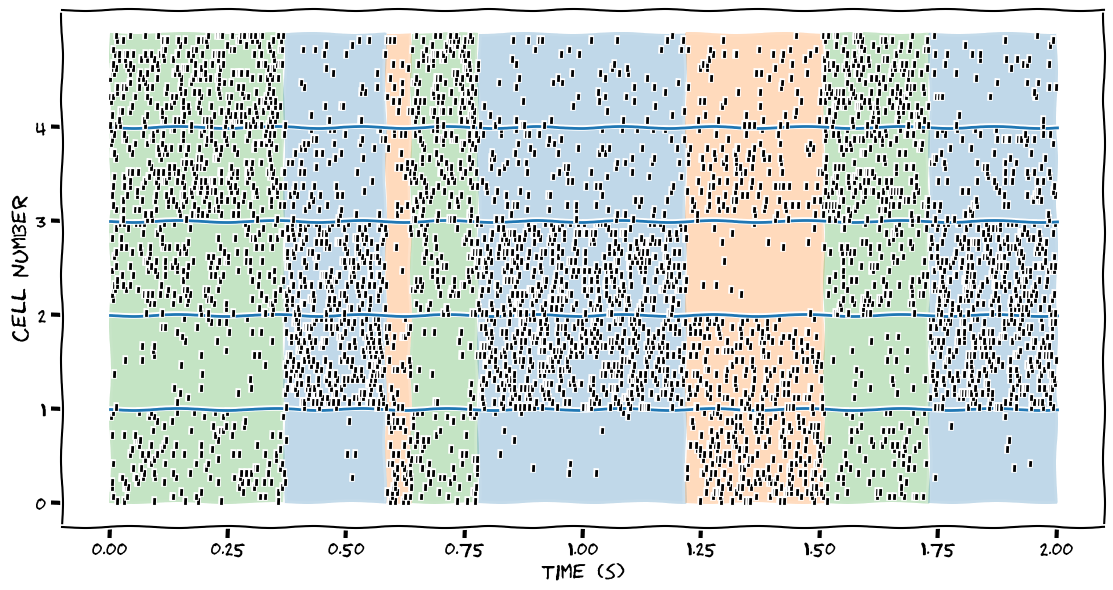

In [8]:
np.random.seed(101)
# sample n_frozen_trials state sequences
Xf = np.zeros(T, dtype=int)
Xf[0] = (psi.cumsum() > np.random.rand()).argmax()
for t in range(1, T):
  Xf[t] = (A[Xf[t - 1],:].cumsum() > np.random.rand()).argmax()

# switch to one-hot encoding of the state
Xf = np.eye(K, dtype=int)[Xf]  # (T,K)

# get the Y values
Rates = np.squeeze(L @ Xf[..., None]) * dt  # (T,C)

Rates = np.tile(Rates, [n_frozen_trials, 1, 1]) # (n_trials, T, C)
Yf = stats.poisson(Rates).rvs()

with plt.xkcd():
  plot_spike_train(Xf, Yf, dt)

#### Generate data for EM learning

The previous dataset is generated with the same state sequence for visualization. Now let's generate `n_trials` trials of observations, each one with its own randomly generated sequence

In [9]:
np.random.seed(101)
# sample n_trials state sequences
X = np.zeros((n_trials, T), dtype=int)
X[:, 0] = (psi_true.cumsum(0)[:, None] > np.random.rand(n_trials)).argmax(0)
for t in range(1, T):
  X[:, t] = (A_true[X[:, t - 1], :].T.cumsum(0) > np.random.rand(n_trials)).argmax(0)

# switch to one-hot encoding of the state
one_hot = np.eye(K)[np.array(X).reshape(-1)]
X = one_hot.reshape(list(X.shape) + [K])

# get the Y values
Y = stats.poisson(np.squeeze(L_true @ X[..., None]) * dt).rvs()  # (n_trials, T, C)
print("Y has shape: (n_trial={},T={},C={})".format(*Y.shape))

Y has shape: (n_trial=300,T=1000,C=5)


---

# Section 2: EM algorithm for HMM

#####  Video 3: EM Tutorial


Video available at https://youtu.be/umU4wUWlKvg


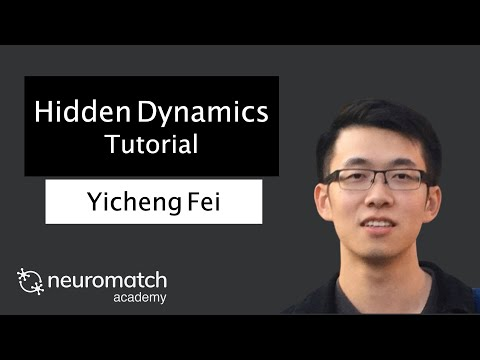

In [10]:
#@title Video 3: EM Tutorial
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="umU4wUWlKvg", width=730, height=410, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Finding the optimal values of parameters that maximizes the data likelihood is practically infeasible since we need to integrating out all latent variables $x_{1:T}$. The time needed is exponential to $T$. Thus as an alternative approach, we use the Expectation-Maximization algorithm, which iteratively performs an E-step followed by a M-step and is guaranteed to not decrease(usually increase) the data likelihood after each EM cycle.


In this section we will briefly review the EM algorithm  for HMM and list

* Recursive equations for forward and backward probabilities $a_i(t)$ and $b_i(t)$
* Expressions for singleton and pairwise marginal distributions after seeing data: $\gamma_{i}(t):=p_{\theta}\left(x_{t}=i | Y_{1: T}\right)$ and $\xi_{i j}(t) = p_{\theta}(x_t=i,x_{t+1}=j|Y_{1:T})$
* Closed-form solutions for updated values of $A,\psi,\lambda$ which increases data likelihood


### E-step: Forward-backward algorithm 
In the forward pass, we calculate the **forward probabilities**, or the joint probability of $x_t$ and current and past data $Y_{1:t}$: $a_i(t):=p(x_t=i,Y_{1:t})$ recursively by

\begin{equation}
a_i(t) = p_(y_t|x_i=t)\sum_j A_{ji} a_j(t-1)
\end{equation}

In contrast to the intro, now $A_{ji}$ means **the transition probability from state $j$ to state $i$.**

The backward pass calculate the **backward probabilities** $b_i(t):=p_{\theta}(Y_{t+1:T}|x_t=i)$, which is the likelihood of observing all future data points given current state $x_t$. The recursion of $b_i(t)$ is given by 

\begin{equation}
b_i(t) = \sum_j p_{\theta}(y_{t+1}|x_{t+1}=j)b_j(t+1)A_{ij}
\end{equation}

Combining all past and future information, the **singleton and pairwise marginal distributions** are given by 

\begin{equation}
\gamma_{i}(t):=p_{\theta}\left(x_{t}=i | Y_{1: T}\right)=\frac{a_{i}(t) b_{i}(t)}{p_{\theta}\left(Y_{1: T}\right)}
\end{equation}

\begin{equation}
\xi_{i j}(t) = p_{\theta}(x_t=i,x_{t+1}=j|Y_{1:T}) =\frac{b_{j}(t+1)p_{\theta}\left(y_{t+1} | x_{t+1}=j\right) A_{i j} a_{i}(t)}{p_{\theta}\left(Y_{1: T}\right)}
\end{equation}

where $p_{\theta}(Y_{1:T})=\sum_i a_i(T)$.

### M-step

The M-step for HMM has a closed-form solution. First the new transition matrix is given by 

\begin{equation}
A_{ij} =\frac{\sum_{t=1}^{T-1} \xi_{i j}(t)}{\sum_{t=1}^{T-1} \gamma_{i}(t)}
\end{equation}

which is the expected empirical transition probabilities. 
New initial probabilities and parameters of the emission models are also given by their empirical values given single and pairwise marginal distributions:

\begin{align}
\psi_i &= \frac{1}{N}\sum_{trials}\gamma_i(1) \\
\lambda_{i}^{c} &= \frac{\sum_{t} \gamma_{i}(t) y_{t}^{c}}{\sum_{t} \gamma_{i}(t) d t}
\end{align}

### E-step: forward and backward algorithm

**(Optional)**

In this section you will read through the code for the forward-backward algorithm and understand how to implement the computation efficiently in `numpy` by calculating the recursion for all trials at once.

Let's re-write the forward and backward recursions in a more compact form:

\begin{eqnarray}
a_i^t &=& \sum_j A_{ji}o_j^t a_j^{t-1}\\
b^t_i &=& \sum_j A_{ij} o_j^{t+1}b_j^{t+1} \text{, where } o_j^{t}=p(y_{t}|x_{t}=j)
\end{eqnarray}


Let's take the backward recursion for example. In practice we will handle all trials together since they are independent of each other. After adding a trial index $l$ to the recursion equations, the backward recursion becomes:

\begin{equation}
b^t_{li} = \sum_j A_{ij} o_{lj}^{t+1}b_{lj}^{t+1}
\end{equation}

What we have in hand are:
* `A`: matrix of size `(K,K)`
* `o^{t+1}`: array of size `(N,K)` is the log data likelihood for all trials at a given time
* `b^{t+1}`: array of size `(N,K)` is the backward probability for all trials at a given time

where `N` stands for the number of trials.

The index size and meaning doesn't match for these three arrays: the index is $i$ for $A$ in the first dimension and is $l$ for $o$ and $b$, so we can't just multiply them together. However, we can do this by viewing vectors $o^{t+1}_{l\cdot}$ and $b^{t+1}_{l\cdot}$ as a matrix with 1 row and re-write the backward equation as:

\begin{equation}
b^t_{li} = \sum_j A_{ij} o_{l1j}^{t+1}b_{l1j}^{t+1}
\end{equation}

Now we can just multiply these three arrays element-wise and sum over the last dimension.

In `numpy`, we can achieve this by indexing the array with `None` at the location we want to insert a dimension. Take `b` with size `(N,T,K)` for example,`b[:,t,:]` will have shape `(N,K)`, `b[:,t,None,:]` will have shape `(N,1,K)` and `b[:,t,:,None]` will have shape `(N,K,1)`.

So the backward recursion computation can be implemented as 

```python
b[:,t,:] = (A * o[:,t+1,None,:] * b[:,t+1,None,:]).sum(-1)
```

<br>

In addition to the trick introduced above, in this exercise we will work on the **log scale** for numerical stability.

**Suggestions:** Take a look at the code for the forward recursion and backward recursion.

In [11]:
def e_step(Y, psi, A, L, dt):
  """Calculate the E-step for the HMM spiking model.

  Args:
    Y (numpy 3d array): tensor of recordings, has shape (n_trials, T, C)
    psi (numpy vector): initial probabilities for each state
    A (numpy matrix):   transition matrix, A[i,j] represents the prob to
                        switch from i to j. Has shape (K,K)
    L (numpy matrix):   Poisson rate parameter for different cells.
                        Has shape (C,K)
    dt (float):         Bin length

  Returns:
    ll (float):             data log likelihood
    gamma (numpy 3d array): singleton marginal distribution.
                            Has shape (n_trials, T, K)
    xi (numpy 4d array):    pairwise marginal distribution for adjacent
                            nodes . Has shape (n_trials, T-1, K, K)
  """
  n_trials = Y.shape[0]
  T = Y.shape[1]
  K = psi.size
  log_a = np.zeros((n_trials, T, K))
  log_b = np.zeros((n_trials, T, K))

  log_A = np.log(A)
  log_obs = stats.poisson(L * dt).logpmf(Y[..., None]).sum(-2)  # n_trials, T, K

  # forward pass
  log_a[:, 0] = log_obs[:, 0] + np.log(psi)
  for t in range(1, T):
    tmp = log_A + log_a[:, t - 1, : ,None]  # (n_trials, K,K)
    maxtmp = tmp.max(-2)  # (n_trials,K)
    log_a[:, t] = (log_obs[:, t] + maxtmp +
                    np.log(np.exp(tmp - maxtmp[:, None]).sum(-2)))

  # backward pass
  for t in range(T - 2, -1, -1):
    tmp = log_A + log_b[:, t + 1, None] + log_obs[:, t + 1, None]
    maxtmp = tmp.max(-1)
    log_b[:, t] = maxtmp + np.log(np.exp(tmp - maxtmp[..., None]).sum(-1))

  # data log likelihood
  maxtmp = log_a[:, -1].max(-1)
  ll = np.log(np.exp(log_a[:, -1] - maxtmp[:, None]).sum(-1)) + maxtmp

  # singleton and pairwise marginal distributions
  gamma = np.exp(log_a + log_b - ll[:, None, None])
  xi = np.exp(log_a[:, :-1, :, None] + (log_obs + log_b)[:, 1:, None] +
              log_A - ll[:, None, None, None])

  return ll.mean() / T / dt, gamma, xi

####  Video 4: Implement the M-step


Video available at https://youtu.be/H4GGTg_9BaE


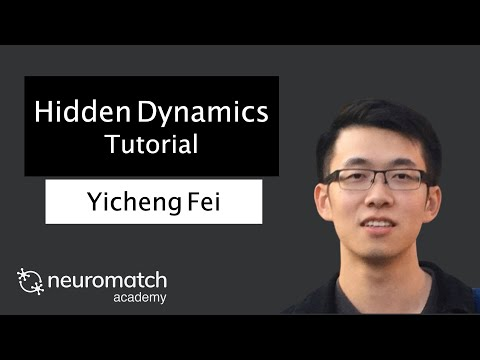

In [12]:
#@title Video 4: Implement the M-step
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="H4GGTg_9BaE", width=730, height=410, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

#### Coding Exercise 2: Implement the M-step

In this exercise you will complete the M-step for this HMM using closed form solutions mentioned before.

**Suggestions**

1. Calculate new initial probabilities as empirical counts of singleton marginals

\begin{equation}
\psi_i = \frac{1}{N}\sum_{trials}\gamma_i(1)
\end{equation}

2. Remember the extra trial dimension and average over all trials

<br>

**For reference:**

New transition matrix is calculated as empirical counts of transition events from marginals

\begin{equation}
A_{ij} =\frac{\sum_{t=1}^{T-1} \xi_{i j}(t)}{\sum_{t=1}^{T-1} \gamma_{i}(t)}
\end{equation}

New spiking rates for each cell and each state are given by

\begin{equation}
\lambda_{i}^{c}=\frac{\sum_{t} \gamma_{i}(t) y_{t}^{c}}{\sum_{t} \gamma_{i}(t) d t}
\end{equation}

In [13]:
def m_step(gamma, xi, dt):
  """Calculate the M-step updates for the HMM spiking model.

  Args:
    gamma ():       Number of epochs of EM to run
    xi (numpy 3d array): Tensor of recordings, has shape (n_trials, T, C)
    dt (float):         Duration of a time bin

  Returns:
    psi_new (numpy vector): Updated initial probabilities for each state
    A_new (numpy matrix):   Updated transition matrix, A[i,j] represents the
                            prob. to switch from j to i. Has shape (K,K)
    L_new (numpy matrix):   Updated Poisson rate parameter for different
                            cells. Has shape (C,K)
  """
  raise NotImplementedError("`m_step` need to be implemented")
  ############################################################################
  # Insert your code here to:
  #    Calculate the new prior probabilities in each state at time 0
  #    Hint: Take the first time step and average over all trials
  ###########################################################################
  psi_new = ...
  # Make sure the probabilities are normalized
  psi_new /= psi_new.sum()

  # Calculate new transition matrix
  A_new = xi.sum(axis=(0, 1)) / gamma[:, :-1].sum(axis=(0, 1))[:, np.newaxis]
  # Calculate new firing rates
  L_new = (np.swapaxes(Y, -1, -2) @ gamma).sum(axis=0) / gamma.sum(axis=(0, 1)) / dt
  return psi_new, A_new, L_new

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial5_Solution_ab737584.py)



#####  Video 5: Running and plotting EM


Video available at https://youtu.be/6UTsXxE3hG0


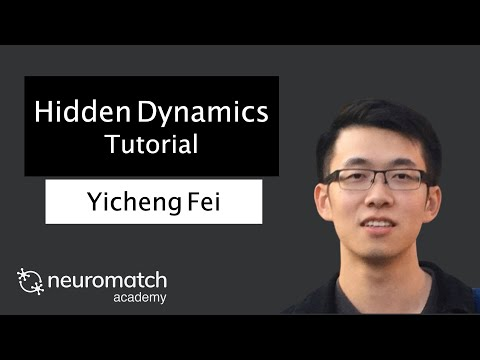

In [14]:
#@title Video 5: Running and plotting EM
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="6UTsXxE3hG0", width=730, height=410, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---

### Run EM

####Initialization for parameters


In [15]:
np.random.seed(101)
# number of EM steps
epochs = 9
print_every = 1

# initial state distribution
psi = np.arange(1, K + 1)
psi = psi / psi.sum()

# off-diagonal transition rates sampled uniformly
A = np.ones((K, K)) * max_transition_rate * dt / 2
A = (1 - np.eye(K)) * A
A = A + np.diag(1 - A.sum(1))

# firing rates sampled uniformly
L = np.random.rand(C, K) * max_firing_rate

In [16]:
# LL for true vs. initial parameters
print(f'LL for true 𝜃:    {e_step(Y, psi_true, A_true, L_true, dt)[0]}')
print(f'LL for initial 𝜃: {e_step(Y, psi, A, L, dt)[0]}\n')

# Run EM
save_vals, lls, psi, A, L = run_em(epochs, Y, psi, A, L, dt)

LL for true 𝜃:    -455.8684143040628


LL for initial 𝜃: -481.5065734432824



epoch:   0, ll = -481.5065734432824


NotImplementedError: `m_step` need to be implemented

In [17]:
# EM doesn't guarantee the order of learnt latent states are the same as that of true model
# so we need to sort learnt parameters

# Compare all true and estimated latents across cells
cost_mat = np.sum((L_true[..., np.newaxis] - L[:, np.newaxis])**2, axis=0)
true_ind, est_ind = linear_sum_assignment(cost_mat)

psi = psi[est_ind]
A = A[est_ind]
A = A[:, est_ind]
L = L[:, est_ind]

## Plotting the training process and learnt model

### Plotting progress during EM!

Now you can

* Plot the likelihood during training
* Plot the M-step log likelihood versus expected complete log likelihood(ECLL)to get an intuition of how EM works and the convexity of ECLL
* Plot learnt parameters versus true parameters

In [18]:
# Plot the log likelihood after each epoch of EM
with plt.xkcd():
  plot_lls(lls)

NameError: name 'lls' is not defined

In [19]:
# For each saved epoch, plot the log likelihood and expected complete log likelihood
# for the initial and final parameter values
with plt.xkcd():
  plot_lls_eclls(plot_epochs, save_vals)

NameError: name 'save_vals' is not defined

### Plot learnt parameters vs. true parameters

Now we will plot the (sorted) learnt parameters with true parameters to see if we successfully recovered all the parameters.

/tmp/ipykernel_6840/180609753.py:196: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot([-10^6], [-10^6], '.', marker=['o', '*', 'd'][i], c="black")
findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Comic Neue' not found.


findfont: Font family 'Comic Sans MS' not found.


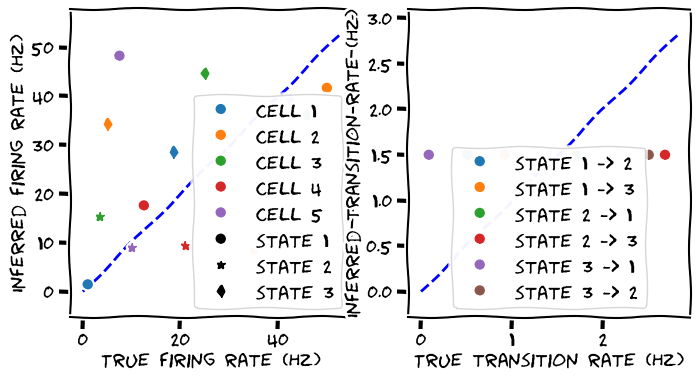

In [20]:
# Compare true and learnt parameters
with plt.xkcd():
  plot_learnt_vs_true(L_true, L, A_true, A, dt)